# Sparkify: Feature extraction and ML model tuning


In this notebook we do the feature extraction and model tuning  with the mini data set (128MB)

In [1]:
import ibmos2spark
# @hidden_cell
credentials = {
    'endpoint': 'https://s3-api.us-geo.objects.service.networklayer.com',
    'service_id': 'iam-ServiceId-xxxx,
    'iam_service_endpoint': 'https://iam.bluemix.net/oidc/token',
    'api_key': 'fH1YFBK2C84k1Hwxxxxx'
}

configuration_name = 'os_483417c1de3948ecb5d662217xxxxx'
cos = ibmos2spark.CloudObjectStorage(sc, credentials, configuration_name, 'bluemix_cos')

from pyspark.sql import SparkSession
spark = SparkSession.builder.getOrCreate()
# Since JSON data can be semi-structured and contain additional metadata, it is possible that you might face issues with the DataFrame layout.
# Please read the documentation of 'SparkSession.read()' to learn more about the possibilities to adjust the data loading.
# PySpark documentation: http://spark.apache.org/docs/2.0.2/api/python/pyspark.sql.html#pyspark.sql.DataFrameReader.json

# df_data_1 = spark.read.json(cos.url('medium-sparkify-event-data.json', 'sparkify-donotdelete-pr-oamce1b1oti8al'))
# df_data_1.take(5)


Waiting for a Spark session to start...
Spark Initialization Done! ApplicationId = app-20190613184922-0002
KERNEL_ID = 38ba0b58-0132-42a1-9522-dd0b9a7dbfd7


In [2]:
# import libraries
from pyspark.sql import SparkSession

from pyspark.sql.functions import udf, desc, asc, avg, col, concat, desc, explode, lit, min, max, split,count
from pyspark.sql.types import StringType
from pyspark.sql.types import IntegerType
from pyspark.sql.functions import sum as Fsum

import datetime
from time import time

from pyspark.sql import Window
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
%matplotlib inline

import re

from functools import reduce

In [3]:
# ML imports
from pyspark.ml.feature import Normalizer, StandardScaler, VectorAssembler,StringIndexer
from pyspark.ml.classification import LogisticRegression, GBTClassifier, RandomForestClassifier,LinearSVC 
from pyspark.ml.regression import LinearRegression
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from pyspark.ml import Pipeline

In [4]:
# create a Spark session
spark = SparkSession.builder.appName("Sparkify").getOrCreate()

In [5]:
df = spark.read.json(cos.url('mini_sparkify_event_data.json', 'sparkify-donotdelete-pr-oamce1b1oti8al'))                        
df.persist()

DataFrame[artist: string, auth: string, firstName: string, gender: string, itemInSession: bigint, lastName: string, length: double, level: string, location: string, method: string, page: string, registration: bigint, sessionId: bigint, song: string, status: bigint, ts: bigint, userAgent: string, userId: string]

In [6]:
def cleanDF(df):
    '''
    Clean data frame to avoid empty values.
    
    INPUT: dataframe
    
    OUTPUT: cleaned dataframe
    '''
    df_cleaned = df.filter(df["userId"] != "")
    
    return df_cleaned

In [7]:
df = cleanDF(df)
print("Count after cleaning (empty values of) userid: ", df.count())

Count after cleaning (empty values of) userid:  278154


In [8]:
#define churn
churnedUsers = df.filter(df.page=="Cancellation Confirmation").select("userId").dropDuplicates()
#make a list for userId with churned users
churnedUsersList=[]
for row in churnedUsers.collect():
    churnedUsersList.append((row['userId']))  
#make a df with info containing churned users                       
df= df.withColumn("churn", df.userId.isin(churnedUsersList))
dfp=df.toPandas()
dfp.count()

artist           228108
auth             278154
firstName        278154
gender           278154
itemInSession    278154
lastName         278154
length           228108
level            278154
location         278154
method           278154
page             278154
registration     278154
sessionId        278154
song             228108
status           278154
ts               278154
userAgent        278154
userId           278154
churn            278154
dtype: int64

### Define Churn


In [9]:
#the timestamp in the data is ticks (ms)
#timestamp func needs second as its input
ticks_to_sec=1./1000. #convert from ms to seconds
ticks_to_hours = ticks_to_sec/( 60.0 * 60.0)
ticks_to_days = ticks_to_hours/24.

In [10]:
#time stamp analysis, convert ts and registrtaion time stamps
#then add these two columns to dataframe
#see https://stackoverflow.com/questions/51983037/convert-from-timestamp-to-specific-date-in-pyspark
format_timestamp_udf= udf(lambda x: datetime.datetime.fromtimestamp(x*ticks_to_sec).strftime("%Y-%m-%d %H:%M:%S"))
#event time stamp
df = df.withColumn('event_time', format_timestamp_udf('ts'))
#user registration time stamp
df = df.withColumn('reg_time', format_timestamp_udf('registration'))
dfp=df.toPandas()
dfp.head(5)

,artist,auth,firstName,gender,itemInSession,lastName,length,level,location,method,...,registration,sessionId,song,status,ts,userAgent,userId,churn,event_time,reg_time
0,Martha Tilston,Logged In,Colin,M,50,Freeman,277.89016,paid,"Bakersfield, CA",PUT,...,1538173362000,29,Rockpools,200,1538352117000,Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) G...,30,False,2018-10-01 00:01:57,2018-09-28 22:22:42
1,Five Iron Frenzy,Logged In,Micah,M,79,Long,236.09424,free,"Boston-Cambridge-Newton, MA-NH",PUT,...,1538331630000,8,Canada,200,1538352180000,"""Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebK...",9,False,2018-10-01 00:03:00,2018-09-30 18:20:30
2,Adam Lambert,Logged In,Colin,M,51,Freeman,282.82730,paid,"Bakersfield, CA",PUT,...,1538173362000,29,Time For Miracles,200,1538352394000,Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) G...,30,False,2018-10-01 00:06:34,2018-09-28 22:22:42
3,Enigma,Logged In,Micah,M,80,Long,262.71302,free,"Boston-Cambridge-Newton, MA-NH",PUT,...,1538331630000,8,Knocking On Forbidden Doors,200,1538352416000,"""Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebK...",9,False,2018-10-01 00:06:56,2018-09-30 18:20:30
4,Daft Punk,Logged In,Colin,M,52,Freeman,223.60771,paid,"Bakersfield, CA",PUT,...,1538173362000,29,Harder Better Faster Stronger,200,1538352676000,Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) G...,30,False,2018-10-01 00:11:16,2018-09-28 22:22:42


In [11]:
#number days passed since the user registered
#find difference between event time stamps and  time since registration
tot_duration_df = df.select('userId','registration','ts').withColumn('totDuration',(df.ts-df.registration))
#group and find the maximum value from the difference of a given user
tot_duration_df =tot_duration_df.groupBy('userId').agg({'totDuration':'max'}) 
#change the column name and convert to number of days
tot_duration_df=tot_duration_df.withColumnRenamed('max(totDuration)','totDuration') \
.select('userId', (col('totDuration')*ticks_to_days).alias('totSubscriptionDays'))
tot_duration_df.show(3)
tot_duration_df.count()

+------+-------------------+
|userId|totSubscriptionDays|
+------+-------------------+
|100010|   55.6436574074074|
|200002|  70.07462962962963|
|   125|  71.31688657407408|
+------+-------------------+
only showing top 3 rows



225

In [12]:
#Average number of songs played per session per user
avg_songs_per_session_df = df.where('page == "NextSong"').groupby('userId', 'sessionId').count()\
    .groupby('userId').agg({'count':'avg'})\
    .withColumnRenamed('avg(count)', 'avgSongsPerSession')
  
avg_songs_per_session_df.show(3)
avg_songs_per_session_df.count()

+------+------------------+
|userId|avgSongsPerSession|
+------+------------------+
|100010|39.285714285714285|
|200002|              64.5|
|   125|               8.0|
+------+------------------+
only showing top 3 rows



225

In [13]:
# Roll advert
tot_advert_df = df.select('userID','page').where(df.page == 'Roll Advert').groupBy('userID') \
    .count().withColumnRenamed('count', 'totRollAdvertCount') 
tot_advert_df.show(3)
tot_advert_df.count()

+------+------------------+
|userID|totRollAdvertCount|
+------+------------------+
|100010|                52|
|200002|                 7|
|   125|                 1|
+------+------------------+
only showing top 3 rows



207

In [14]:
# friends added is a measure of user engagement
tot_friends_df = df.select('userID','page').where(df.page == 'Add Friend').groupBy('userID') \
    .count().withColumnRenamed('count', 'totFriendCount') 
tot_friends_df.show(3)
tot_friends_df.count()

+------+--------------+
|userID|totFriendCount|
+------+--------------+
|100010|             4|
|200002|             4|
|    51|            28|
+------+--------------+
only showing top 3 rows



206

In [15]:
#total thumps up or thumps down is an indicator of user engagement
#and hence a good feature to predict churn
tot_thumps_Up_df= df.select('userID','page').select('userID','page').where(df.page == 'Thumbs Up').groupBy('userID') \
    .count().withColumnRenamed('count', 'totThumpsUp') 
tot_thumps_Up_df.show(3)
print("tot thumps up user counts", tot_thumps_Up_df.count())

tot_thumps_Down_df= df.select('userID','page').select('userID','page').where(df.page == 'Thumbs Down').groupBy('userID') \
    .count().withColumnRenamed('count', 'totThumpsDown') 
tot_thumps_Down_df.show(3)
tot_thumps_Down_df.count()
print("tot thumps down user counts", tot_thumps_Down_df.count())

+------+-----------+
|userID|totThumpsUp|
+------+-----------+
|100010|         17|
|200002|         21|
|    51|        100|
+------+-----------+
only showing top 3 rows

tot thumps up user counts 220
+------+-------------+
|userID|totThumpsDown|
+------+-------------+
|100010|            5|
|200002|            6|
|    51|           21|
+------+-------------+
only showing top 3 rows

tot thumps down user counts 203


In [16]:
#total number of songs listened 
tot_songs_count_df= df.select('userID','song').groupBy('userID').count().withColumnRenamed('count', 'totalSongCount')
tot_songs_count_df.show(3)
tot_songs_count_df.count()

+------+--------------+
|userID|totalSongCount|
+------+--------------+
|100010|           381|
|200002|           474|
|   125|            11|
+------+--------------+
only showing top 3 rows



225

In [17]:
#total number of songs added to play list
tot_songsAdded_count_df= df.select('userID','page').select('userID','page').where(df.page == 'Add to Playlist').groupBy('userID') \
    .count().withColumnRenamed('count', 'totSongsAdded')
tot_songsAdded_count_df.show(3)
#tot_songsAdded_count_df.fillna(0)
tot_songsAdded_count_df.count()

+------+-------------+
|userID|totSongsAdded|
+------+-------------+
|100010|            7|
|200002|            8|
|   124|          118|
+------+-------------+
only showing top 3 rows



215

In [18]:
# convert gender flag  to numeric values for ML, M =1 and F =0
gender_df = df.select("userId", "gender").dropDuplicates().replace(['M', 'F'], ['1', '0'], 'gender') \
    .select('userId', col('gender').cast('int'))
gender_df.show(15)
gender_df.count()

+------+------+
|userId|gender|
+------+------+
|    44|     0|
|    46|     0|
|    41|     0|
|    72|     0|
|300023|     0|
|    39|     0|
|100010|     0|
|    40|     0|
|    94|     0|
|    35|     0|
|    75|     0|
|   116|     0|
|200001|     1|
|200020|     1|
|100008|     0|
+------+------+
only showing top 15 rows



225

In [19]:
# convert churn labels to numeric values, churned =1 and stayed =0
churn_numeric_df = df.select("userId", "churn").dropDuplicates().replace(['True', 'False'], ['1', '0'], 'churn') \
    .select('userId', col('churn').cast('int'))
churn_numeric_df.show(20)
churn_numeric_df.count()

+------+-----+
|userId|churn|
+------+-----+
|    19|    0|
|100005|    1|
|200007|    0|
|300007|    1|
|    50|    0|
|200002|    0|
|    30|    0|
|     8|    0|
|100011|    1|
|100012|    1|
|     4|    0|
|    65|    0|
|    13|    0|
|   101|    1|
|   153|    0|
|    42|    0|
|100014|    1|
|    94|    0|
|    62|    0|
|   114|    0|
+------+-----+
only showing top 20 rows



225

Now let us put all the features together and make a data frame for ML

In [20]:
df_final = df.dropDuplicates(['userId']).select(['userId'])

for feature in [tot_duration_df,avg_songs_per_session_df, tot_advert_df, tot_friends_df, \
                tot_thumps_Up_df,tot_thumps_Down_df,tot_songs_count_df,tot_songsAdded_count_df, \
                gender_df,churn_numeric_df]:
    df_final = df_final.join(feature,on='userId',how='left').fillna(0)
    
df_final = df_final.orderBy('userId', ascending=True) #SPARK
df_final.show(3)
                            
dfp_final=df_final.toPandas() #PANDAS
dfp_final.head(5)

+------+-------------------+------------------+------------------+--------------+-----------+-------------+--------------+-------------+------+-----+
|userId|totSubscriptionDays|avgSongsPerSession|totRollAdvertCount|totFriendCount|totThumpsUp|totThumpsDown|totalSongCount|totSongsAdded|gender|churn|
+------+-------------------+------------------+------------------+--------------+-----------+-------------+--------------+-------------+------+-----+
|    10|  51.76265046296296|112.16666666666667|                 1|            12|         37|            4|           795|            9|     1|    0|
|   100|  64.87377314814815| 78.88235294117646|                25|            49|        148|           27|          3214|           61|     1|    0|
|100001|  44.80021990740741|             33.25|                14|             2|          8|            2|           187|            3|     0|    1|
+------+-------------------+------------------+------------------+--------------+-----------+-------

,userId,totSubscriptionDays,avgSongsPerSession,totRollAdvertCount,totFriendCount,totThumpsUp,totThumpsDown,totalSongCount,totSongsAdded,gender,churn
0,10,51.762650,112.166667,1,12,37,4,795,9,1,0
1,100,64.873773,78.882353,25,49,148,27,3214,61,1,0
2,100001,44.800220,33.250000,14,2,8,2,187,3,0,1
3,100002,160.472072,48.750000,3,1,5,0,218,5,0,0
4,100003,22.748113,25.500000,9,0,3,0,78,2,0,1


In [21]:
dfp_final.count()

userId                 225
totSubscriptionDays    225
avgSongsPerSession     225
totRollAdvertCount     225
totFriendCount         225
totThumpsUp            225
totThumpsDown          225
totalSongCount         225
totSongsAdded          225
gender                 225
churn                  225
dtype: int64

In [22]:
df_final.dtypes

[('userId', 'string'),
 ('totSubscriptionDays', 'double'),
 ('avgSongsPerSession', 'double'),
 ('totRollAdvertCount', 'bigint'),
 ('totFriendCount', 'bigint'),
 ('totThumpsUp', 'bigint'),
 ('totThumpsDown', 'bigint'),
 ('totalSongCount', 'bigint'),
 ('totSongsAdded', 'bigint'),
 ('gender', 'int'),
 ('churn', 'int')]

In [23]:
# convert  (userId) to integer since it is shown as string
df_final = df_final.withColumn('userId', df_final.userId.cast(IntegerType()))
df_final.printSchema()

root
 |-- userId: integer (nullable = true)
 |-- totSubscriptionDays: double (nullable = false)
 |-- avgSongsPerSession: double (nullable = false)
 |-- totRollAdvertCount: long (nullable = true)
 |-- totFriendCount: long (nullable = true)
 |-- totThumpsUp: long (nullable = true)
 |-- totThumpsDown: long (nullable = true)
 |-- totalSongCount: long (nullable = true)
 |-- totSongsAdded: long (nullable = true)
 |-- gender: integer (nullable = true)
 |-- churn: integer (nullable = true)



In [24]:
#check we have the correct number of churn values still
df_final.groupby("churn").count().show()

+-----+-----+
|churn|count|
+-----+-----+
|    1|   52|
|    0|  173|
+-----+-----+



# Modeling
- Split the full dataset into train, test, and validation sets.
- Test out several of the machine learning methods.
- Evaluate the accuracy of the various models

In [25]:
# split into train 60%, test 20% and validation 20%
train, testAndValidation = df_final.randomSplit([0.6, 0.4], seed = 42)
test, validation = testAndValidation.randomSplit([0.5, 0.5], seed = 42)
#test.show(2)

In [26]:
# create vector for features (no userID or churn needed)
cols = ['totSubscriptionDays', 'avgSongsPerSession','totRollAdvertCount', 'totFriendCount','totThumpsUp', \
        'totThumpsDown','totalSongCount','totSongsAdded','gender']

#vector assembler, combines a given list of columns into a single vector column
assembler = VectorAssembler(inputCols=cols, outputCol='assembledFeatures')

#standardize the features
scaler = StandardScaler(inputCol="assembledFeatures", outputCol="features", withStd=True)

#
indexer = StringIndexer(inputCol="churn", outputCol="label")

In [27]:
def evaluateModel(inputPipeline):
    model_pipeline =inputPipeline
    #Pipeline(stages=[assembler, scaler, indexer, classifier])
    #parameters
    param_grid = ParamGridBuilder().build()
    #evaluator
    F1_evaluator = MulticlassClassificationEvaluator(metricName='f1')
    #crossvalidation
    cv = CrossValidator(estimator=model_pipeline,estimatorParamMaps=param_grid, \
                           evaluator=F1_evaluator,numFolds=3,seed=42)
    
    start = time()
    cvModel = cv.fit(train)
    end = time()
    #print('avg metrics:', cvModel.avgMetrics)
    print('The training process took {} seconds'.format(end - start))
    results = cvModel.transform(validation)
    TP = results.filter("label = 1 and prediction = 1").count()
    TN = results.filter("label = 0 and prediction = 0").count()
    FP = results.filter("label = 0 and prediction = 1").count()
    FN = results.filter("label = 1 and prediction = 0").count()
    
    accuracy= (TP+TN)/(TP+FP+FN+TN)
    precision = TP / (TP + FP) 
    recall = TP / (TP + FN)
    f1 = 2*precision*recall / (precision+recall)
    
    print('Model Metrics:--------')
    print("Accuracy  :",round(accuracy,4))
    print("Precision :",round(precision,4))
    print("Recall    :",round(recall,4))
    print("F-1 score :",round(f1,4))
    
    #pysparks metric evaluation
    evaluator = MulticlassClassificationEvaluator(predictionCol="prediction")
    print('Model Metrics from pyspark:-----')
    print('Accuracy: {}'.format(evaluator.evaluate(results, {evaluator.metricName: "accuracy"})))
    print('F-1 Score:{}'.format(evaluator.evaluate(results, {evaluator.metricName: "f1"})))

In [28]:
# Random Forest model
classifier=RandomForestClassifier(seed=42)
rf_pipeline = Pipeline(stages=[assembler, scaler, indexer, classifier])
evaluateModel(rf_pipeline)

The training process took 239.10936546325684 seconds
Model Metrics:--------
Accuracy  : 0.8354
Precision : 0.6154
Recall    : 0.5
F-1 score : 0.5517
Model Metrics from pyspark:-----
Accuracy: 0.8354430379746836
F-1 Score:0.8288449240201801


In [29]:
# Logistic regression model 
classifier=LogisticRegression(maxIter=10)
lr_pipeline = Pipeline(stages=[assembler, scaler, indexer, classifier])
evaluateModel(lr_pipeline)

The training process took 204.19770979881287 seconds
Model Metrics:--------
Accuracy  : 0.8608
Precision : 0.7778
Recall    : 0.4375
F-1 score : 0.56
Model Metrics from pyspark:-----
Accuracy: 0.8607594936708861
F-1 Score:0.8449300466355762


In [30]:
#Gradient-Boosted Trees
classifier=GBTClassifier(maxIter=10,seed=42)
gbt_pipeline = Pipeline(stages=[assembler, scaler, indexer, classifier])
evaluateModel(gbt_pipeline)

The training process took 543.3622953891754 seconds
Model Metrics:--------
Accuracy  : 0.7215
Precision : 0.375
Recall    : 0.5625
F-1 score : 0.45
Model Metrics from pyspark:-----
Accuracy: 0.7215189873417721
F-1 Score:0.7399270542801974


## Hyperparameter tuning

In [31]:
#Hyperparameter tuning, RF
classifier=RandomForestClassifier(seed=42)
model_pipeline = Pipeline(stages=[assembler, scaler, indexer, classifier])

#parameters
param_grid = ParamGridBuilder() \
    .addGrid(classifier.maxDepth,[5,6]) \
    .addGrid(classifier.impurity,['entropy','gini']) \
    .addGrid(classifier.minInstancesPerNode,[1] ) \
    .addGrid(classifier.numTrees,[25,30]) \
    .build()

#evaluator
F1_evaluator = MulticlassClassificationEvaluator(metricName='f1')
#crossvalidation
cv = CrossValidator(estimator=model_pipeline,estimatorParamMaps=param_grid, \
                           evaluator=F1_evaluator,numFolds=3,seed=42)
    

In [32]:
start = time()
cvModel = cv.fit(train)
end = time()
print('The training process took {} seconds'.format(end - start))


The training process took 806.46484375 seconds


In [33]:
#get the detailed results of cross validation
#see https://stackoverflow.com/questions/51230726/extract-results-from-crossvalidator-with-paramgrid-in-pyspark

params = [{p.name: v for p, v in m.items()} for m in cvModel.getEstimatorParamMaps()]

# convert pandas dataframe and print out
cv_metricAndParams = pd.DataFrame.from_dict([
    {cvModel.getEvaluator().getMetricName(): metric, **ps} 
    for ps, metric in zip(params, cvModel.avgMetrics)
])
cv_metricAndParams 

,f1,impurity,maxDepth,minInstancesPerNode,numTrees
0,0.862450,entropy,5,1,25
1,0.823389,entropy,5,1,30
2,0.842525,gini,5,1,25
3,0.845612,gini,5,1,30
4,0.862450,entropy,6,1,25
5,0.823389,entropy,6,1,30
6,0.840376,gini,6,1,25
7,0.845612,gini,6,1,30


In [34]:
bestModel = cvModel.bestModel
#print('avg metrics:', cvModel.avgMetrics)
results = bestModel.transform(validation)
TP = results.filter("label = 1 and prediction = 1").count()
TN = results.filter("label = 0 and prediction = 0").count()
FP = results.filter("label = 0 and prediction = 1").count()
FN = results.filter("label = 1 and prediction = 0").count()
    
accuracy= (TP+TN)/(TP+FP+FN+TN)
precision = TP / (TP + FP) 
recall = TP / (TP + FN)
f1 = 2*precision*recall / (precision+recall)


print('')
print('Model Metrics:--------')
print("Accuracy  :",round(accuracy,4))
print("Precision :",round(precision,4))
print("Recall    :",round(recall,4))
print("F-1 score :",round(f1,4))

#pysparks metric evaluation
evaluator = MulticlassClassificationEvaluator(predictionCol="prediction")
print('Model Metrics from pyspark:-----')
print('Accuracy: {}'.format(evaluator.evaluate(results, {evaluator.metricName: "accuracy"})))
print('F-1 Score:{}'.format(evaluator.evaluate(results, {evaluator.metricName: "f1"})))


Model Metrics:--------
Accuracy  : 0.8608
Precision : 0.7273
Recall    : 0.5
F-1 score : 0.5926
Model Metrics from pyspark:-----
Accuracy: 0.8607594936708861
F-1 Score:0.8505241157671344


In [35]:
#extract parameters from  the best model
print ('Best Param (MaxDepth): ', bestModel.stages[-1]._java_obj.getMaxDepth())
print ('Best Param (impurity): ', bestModel.stages[-1]._java_obj.getImpurity())
print ('Best Param (No trees): ', bestModel.stages[-1]._java_obj.getNumTrees())
print ('Best Param (No Instances): ', bestModel.stages[-1]._java_obj.getMinInstancesPerNode())
#print ('Best Param (No Instances): ', bestModel.stages[-1]._java_obj.getFeatureSubsetStrategy())


Best Param (MaxDepth):  5
Best Param (impurity):  entropy
Best Param (No trees):  25
Best Param (No Instances):  1


## Extract important features

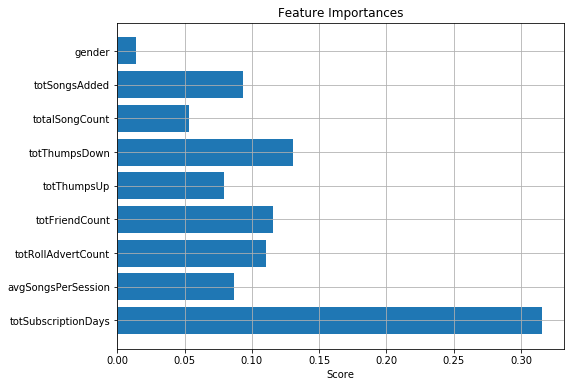

In [39]:
importantFeatures = bestModel.stages[-1].featureImportances.values
cols = ['totSubscriptionDays', 'avgSongsPerSession','totRollAdvertCount', 'totFriendCount','totThumpsUp', \
        'totThumpsDown','totalSongCount','totSongsAdded','gender']

y_pos = np.arange(len(cols))
plt.figure(figsize=(8,6))
plt.barh(y_pos,importantFeatures)
plt.yticks(y_pos, cols)
plt.grid()
plt.xlabel('Score')
plt.title('Feature Importances')
plt.savefig('featImportance_mini.png')